In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import itertools as it

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression
import warnings
np.warnings.filterwarnings('ignore')

In [3]:
# Loading test and train data
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [75]:
train = train.drop(['Unnamed: 0'],axis=1)
test = test.drop(['Unnamed: 0'],axis=1)

In [76]:
# Separate into test and train
y_train = train.target
X_train = train.drop("target", axis = 1)

y_test = test.target
X_test = test.drop('target', axis = 1)

X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [77]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train_columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train_columns)

In [78]:
# Model without any restrictions
model = DecisionTreeClassifier(random_state = 1)

# Compute the pruning path during Minimal Cost-Complexity Pruning
path= model.cost_complexity_pruning_path(X_train,y_train)

In [79]:
alphas=path['ccp_alphas']

In [80]:
len(alphas)

232

## **Coarse Grid Search**

In [81]:
param_grid = {    
    'max_depth': range(0, 50),
    'max_leaf_nodes': range(0, 50),
    'max_features': range(1, 50),
    'ccp_alpha':alphas
}

cv = StratifiedKFold(n_splits=5)

grid_search_model = RandomizedSearchCV(DecisionTreeClassifier(random_state = 1), param_distributions = param_grid, 
                                       scoring = ['accuracy', 'recall'], refit = 'recall', n_jobs=-1, verbose=True,
                                       cv=cv, n_iter = 1000)

grid_search_model.fit(X_train, y_train)

# make the predictions
y_pred = grid_search_model.predict(X_test)

print('Train accuracy : %.3f'%grid_search_model.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search_model.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%grid_search_model.best_score_)

print('Best params for recall')
print(grid_search_model.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Train accuracy : 0.840
Test accuracy : 0.818
Best accuracy Through Grid Search : 0.819
Best params for recall
{'max_leaf_nodes': 47, 'max_features': 47, 'max_depth': 1, 'ccp_alpha': 0.0015143275631222565}


In [82]:
tree = DecisionTreeClassifier(random_state=1, max_depth = 14, max_leaf_nodes=11, max_features=24, 
                              ccp_alpha = 0.00084).fit(X_train, y_train)

cross_val_ypred = cross_val_predict(DecisionTreeClassifier(random_state=1, max_depth = 15, max_leaf_nodes=8, 
                                                           max_features=40, ccp_alpha = 0.000190909090909091), 
                                    X_train, y_train, cv = 5, method = 'predict_proba')

metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)

  accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

In [83]:
metrics.loc[(metrics.accuracy>=80) & (metrics.recall>80), :].sort_values(by = 'recall', ascending = False).iloc[0,:]

threshold     0.181000
accuracy     80.330000
recall       87.074031
Name: 181, dtype: float64

In [84]:
metrics.loc[(metrics.accuracy>=80) & (metrics.recall>80), :].sort_values(by = 'accuracy', ascending = False).iloc[0,:]

threshold     0.226000
accuracy     82.340000
recall       81.511947
Name: 226, dtype: float64

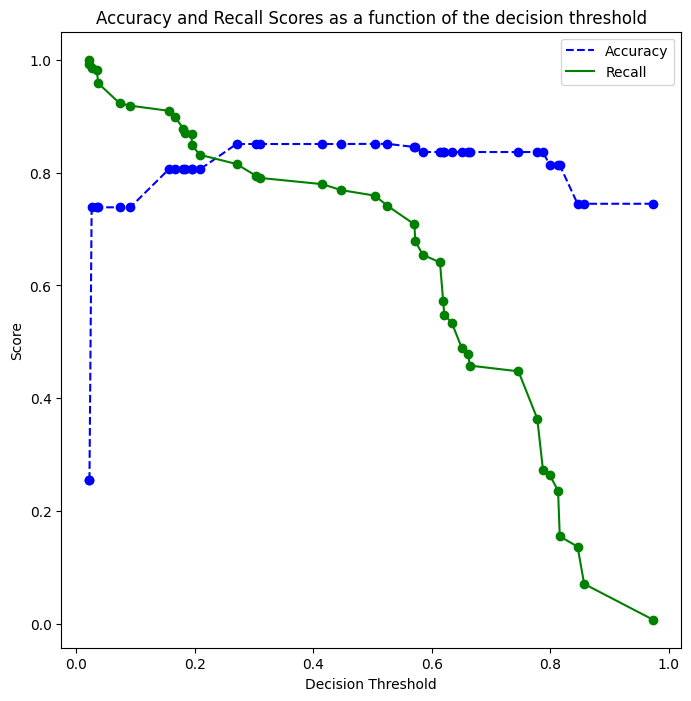

In [85]:
tree = DecisionTreeClassifier(random_state=1, max_depth = 15, max_leaf_nodes=8, max_features=40, 
                              ccp_alpha = 0.000190909090909091)

cross_val_ypred = cross_val_predict(tree, X_train, y_train, cv = 5, method = 'predict_proba')

tree.fit(X_train, y_train)

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []

for t in thresholds:
  y_pred_prob = tree.predict_proba(X_train)[:,1]
  y_pred = y_pred_prob > t
  y_pred = y_pred.astype(int)
  accuracy = (accuracy_score(y_pred, y_train))
  accuracy_list.append(accuracy)

def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
  plt.figure(figsize=(8,8))
  plt.title("Accuracy and Recall Scores as a function of the decision threshold")
  plt.plot(thresholds, accuracy_list, "b--", label = "Accuracy")
  plt.plot(thresholds, recalls[:-1], 'g-', label = "Recall")
  plt.plot(thresholds, accuracy_list, 'o', color = 'blue')
  plt.plot(thresholds, recalls[:-1], 'o', color = 'green')
  plt.ylabel('Score')
  plt.xlabel('Decision Threshold')
  plt.legend(loc='best')
  plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

Accuracy:  80.55
ROC-AUC:  0.9024251597304067
Precision:  0.5765357502517623
Recall:  0.8969839404622013


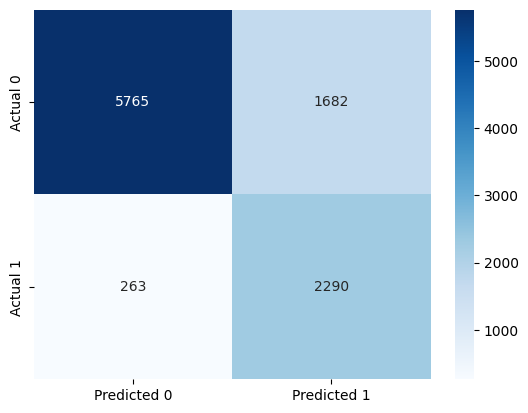

In [86]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.171000

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  79.01
ROC-AUC:  0.86427062804195
Precision:  0.5910316098995344
Recall:  0.848698099929627


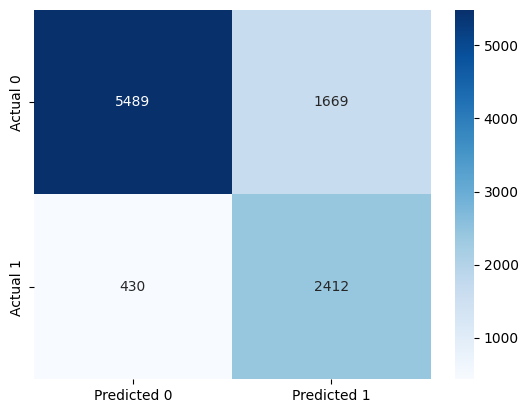

In [87]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.171000

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

## **Fine Grid Search**

In [88]:
param_grid = {    
    'max_depth': range(10, 20),
    'max_leaf_nodes': range(5, 20),
    'max_features': range(20, 30),
    'ccp_alpha':alphas
}

cv = StratifiedKFold(n_splits=5)

grid_search_model = RandomizedSearchCV(DecisionTreeClassifier(random_state = 1), param_distributions = param_grid, 
                                       scoring = ['accuracy', 'recall'], refit = 'recall', n_jobs=-1, verbose=True,
                                       cv=cv, n_iter = 2000)

grid_search_model.fit(X_train, y_train)

# make the predictions
y_pred = grid_search_model.predict(X_test)

print('Train accuracy : %.3f'%grid_search_model.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search_model.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%grid_search_model.best_score_)

print('Best params for recall')
print(grid_search_model.best_params_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Train accuracy : 0.834
Test accuracy : 0.814
Best accuracy Through Grid Search : 0.754
Best params for recall
{'max_leaf_nodes': 5, 'max_features': 20, 'max_depth': 19, 'ccp_alpha': 0.0002964051809718105}


In [89]:
tree = DecisionTreeClassifier(random_state=1, max_depth = 15, max_leaf_nodes=14, max_features=24, 
                              ccp_alpha = 0.002522701041957589).fit(X_train, y_train)

cross_val_ypred = cross_val_predict(DecisionTreeClassifier(random_state=1, max_depth = 15, max_leaf_nodes=8, 
                                                           max_features=40, ccp_alpha = 0.000190909090909091), 
                                    X_train, y_train, cv = 5, method = 'predict_proba')

metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)

  accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

In [90]:
metrics.loc[(metrics.accuracy>=80) & (metrics.recall>80), :].sort_values(by = 'recall', ascending = False).iloc[0,:]

threshold     0.181000
accuracy     80.330000
recall       87.074031
Name: 181, dtype: float64

In [91]:
metrics.loc[(metrics.accuracy>=80) & (metrics.recall>80), :].sort_values(by = 'accuracy', ascending = False).iloc[0,:]

threshold     0.226000
accuracy     82.340000
recall       81.511947
Name: 226, dtype: float64

In [98]:
metrics.iloc[range(200,250), :]

,threshold,accuracy,recall
200,0.200,81.12,83.157070
201,0.201,81.12,83.157070
202,0.202,81.12,83.157070
203,0.203,81.12,83.157070
204,0.204,81.12,83.157070
205,0.205,81.12,83.157070
206,0.206,81.12,83.157070
207,0.207,81.12,83.157070
208,0.208,81.12,83.157070
209,0.209,82.34,81.511947


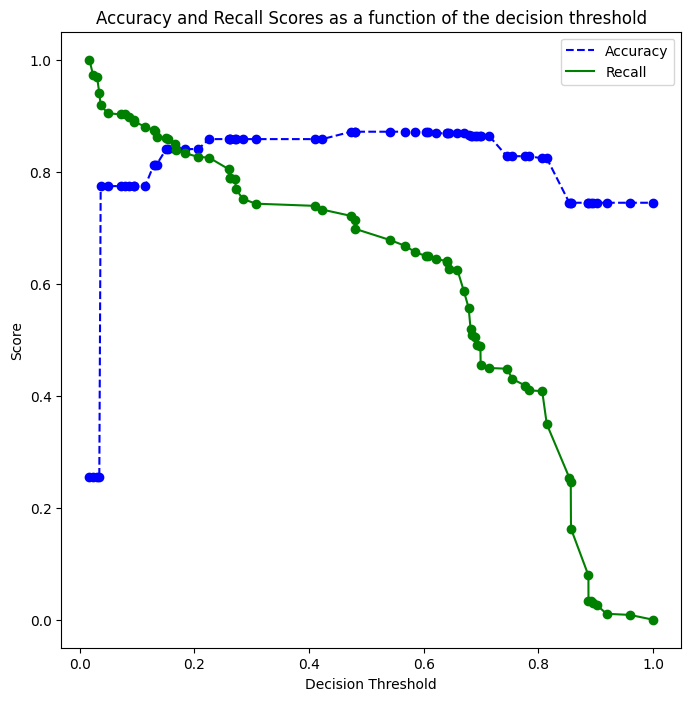

In [93]:
tree = DecisionTreeClassifier(random_state=1, max_depth = 16, max_leaf_nodes=15, max_features=24, 
                              ccp_alpha = 0.002522701041957589)

cross_val_ypred = cross_val_predict(tree, X_train, y_train, cv = 5, method = 'predict_proba')

tree.fit(X_train, y_train)

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []

for t in thresholds:
  y_pred_prob = tree.predict_proba(X_train)[:,1]
  y_pred = y_pred_prob > t
  y_pred = y_pred.astype(int)
  accuracy = (accuracy_score(y_pred, y_train))
  accuracy_list.append(accuracy)

def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
  plt.figure(figsize=(8,8))
  plt.title("Accuracy and Recall Scores as a function of the decision threshold")
  plt.plot(thresholds, accuracy_list, "b--", label = "Accuracy")
  plt.plot(thresholds, recalls[:-1], 'g-', label = "Recall")
  plt.plot(thresholds, accuracy_list, 'o', color = 'blue')
  plt.plot(thresholds, recalls[:-1], 'o', color = 'green')
  plt.ylabel('Score')
  plt.xlabel('Decision Threshold')
  plt.legend(loc='best')
  plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

Accuracy:  85.83
ROC-AUC:  0.9014909433636554
Precision:  0.678391959798995
Recall:  0.8460634547591069


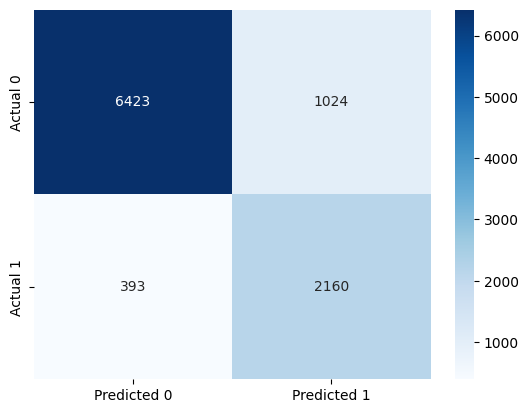

In [99]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.231

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  82.22
ROC-AUC:  0.8538356565853789
Precision:  0.6645021645021645
Recall:  0.7561576354679803


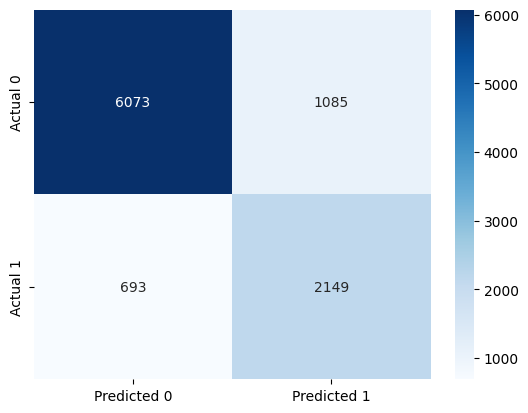

In [100]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.231

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');